# Multilevel Multigrid Example

In [9]:
# dependencies
using LFAToolkit
using LinearAlgebra
using Pkg
Pkg.activate("./")
Pkg.instantiate()
using Plots

 Activating environment at `~/Dev/LFAToolkit.jl/examples/jupyter/Project.toml`


In [10]:
# setup
finep = 5
midp3 = 3
coarsep = 2
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

mtofbasis3 = TensorH1LagrangeBasis(midp3, finep, dimension, lagrangequadrature=true)
ctombasis = TensorH1LagrangeBasis(coarsep, midp3, dimension, lagrangequadrature=true)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
middiffusion3 = GalleryOperator("diffusion", midp3, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Jacobi smoother
finejacobi = Jacobi(finediffusion)
midjacobi3 = Jacobi(middiffusion3)

# p-multigrid preconditioner
midmultigrid3 = PMultigrid(middiffusion3, coarsediffusion, midjacobi3, [ctombasis])
multigrid = PMultigrid(finediffusion, midmultigrid3, finejacobi, [mtofbasis3])

p-multigrid preconditioner

Min ω: [0.855, 0.06046292493189544]


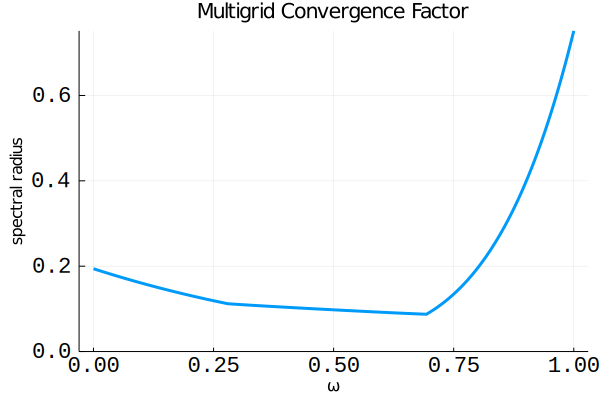

In [14]:
# full operator symbols
numberruns = 100
numberruns_w = 500
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2
ω_max = 1.0

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    smoothingfactor = zeros(numberruns)
    ω_min = [0.0, 1.0]
    v = [2, 2]

    # compute
    for i in 1:numberruns
        ω = [0.0+(ω_max-0.0)*i/numberruns]
        for j in 1:numberruns
            θ = [θ_min + (θ_max - θ_min)*j/numberruns]
            if abs(θ[1] % 2π) >  π/512
                A = computesymbols(multigrid, ω, v, θ)
                eigenvalues = [abs(val) for val in eigvals(A)]
                smoothingfactor[i] = max(smoothingfactor[i], eigenvalues...)
            end
        end
        if smoothingfactor[i] < ω_min[2]
            ω_min = [ω[1], smoothingfactor[i]]
        end
    end

    # plot
    println("Min ω: ", ω_min)
    xrange = 0:ω_max/(numberruns-1):ω_max
    plot(xrange,
        smoothingfactor,
        xlabel="ω",
        xtickfont=font(12, "Courier"),
        ylabel="spectral radius",
        ytickfont=font(12, "Courier"),
        linewidth=3,
        legend=:none,
        title="Multigrid Convergence Factor"
    )
    ylims!(0.0, max(smoothingfactor...))
    savefig("multi_grid_converge_5_to_2_2smooth")
# -- 2D --
elseif dimension == 2
    # setup
    smoothingfactor = zeros(numberruns_w)
    ω_min = [0.0, 1.0]
    v = [3, 3]

    # compute
    for i in 1:numberruns_w
        ω = [0.5+(ω_max-0.5)*i/numberruns_w]
        for j in 1:numberruns, k in 1:numberruns
            θ = [
                θ_min + (θ_max - θ_min)*j/numberruns,
                θ_min + (θ_max - θ_min)*k/numberruns
            ]
            if θ[1] > π/2 || θ[2] > π/2
                A = computesymbols(multigrid, ω, v, θ)
                eigenvalues = [abs(val) for val in eigvals(A)]
                smoothingfactor[i] = max(smoothingfactor[i], eigenvalues...)
                if smoothingfactor[i] < ω_min[2]
                    ω_min = [ω[1], smoothingfactor[i]]
                end
            end
        end
    end

    # plot
    println("Min ω: ", ω_min)
    xrange = 0:ω_max/(numberruns_w-1):ω_max
    plot(xrange,
        smoothingfactor,
        xlabel="ω",
        xtickfont=font(12, "Courier"),
        ylabel="spectral radius",
        ytickfont=font(12, "Courier"),
        linewidth=3,
        legend=:none,
        title="Multigrid Convergence Factor"
    )
    ylims!(0.0, max(smoothingfactor...))
    #savefig("multi_grid_converge_5_to_2_2smooth_2d")
end